In [1]:
import pypsa
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

c:\Users\noraky\anaconda3\envs\pypsa-earth-nora\lib\site-packages\pypsa\networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


In [2]:
#path_name = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/results/networks/elec_s_all_ec_lcopt_Co2L-1H.nc'
path_name = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/monte_carlo_networks/network_101.nc'
#path_name = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/network_check/network_1.nc'
#path_name = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/network_sol.nc'
#path_name = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/30_nodes/elec_s_30_ec_lcopt_Co2L-1H.nc'
#path_name = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/networks/elec_s_all_ec_lcopt_Co2L-1H.nc'
#path_name = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/results_all/r_2024.nc'
#path_name = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/base_nze_period_ends/BNZE_costval_wo_bat_2029.nc'
#path_name = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/base_NZE/BNZE__2040.nc'
#path_name = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/network_bnze_2040/BNZE_2040.nc'
#path_name = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/network_bnze_2040/elec_s_all_ec_lcopt_Co2L-1H.nc'
n = pypsa.Network(path_name)


c:\Users\noraky\anaconda3\envs\pypsa-earth-nora\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\noraky\anaconda3\envs\pypsa-earth-nora\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\noraky\anaconda3\envs\pypsa-earth-nora\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dt

In [43]:
start_year = 2024
start_value = 2740892
end_year = 2050
end_value = 0

years = range(start_year, end_year + 1)
emissions = []

decrease_per_year = (start_value - end_value) / (end_year - start_year)

for i in years:
    emission = max(start_value - decrease_per_year * (i - start_year), end_value)
    emissions.append(emission)

index = np.arange(2024,2051)
emission_limit = dict(zip(index, emissions))
emission_limit

{2024: 2740892.0,
 2025: 2635473.076923077,
 2026: 2530054.153846154,
 2027: 2424635.230769231,
 2028: 2319216.3076923075,
 2029: 2213797.3846153845,
 2030: 2108378.4615384615,
 2031: 2002959.5384615385,
 2032: 1897540.6153846155,
 2033: 1792121.6923076923,
 2034: 1686702.7692307692,
 2035: 1581283.8461538462,
 2036: 1475864.923076923,
 2037: 1370446.0,
 2038: 1265027.076923077,
 2039: 1159608.1538461538,
 2040: 1054189.2307692308,
 2041: 948770.3076923077,
 2042: 843351.3846153845,
 2043: 737932.4615384615,
 2044: 632513.5384615385,
 2045: 527094.6153846155,
 2046: 421675.6923076925,
 2047: 316256.769230769,
 2048: 210837.846153846,
 2049: 105418.923076923,
 2050: 0.0}

In [3]:
def get_emissions(network):
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    return emissions.sum().sum() / 1000000

In [4]:
get_emissions(n)

1.154546308190917

In [5]:
loads = n.generators.query('carrier == "load"').index
LL = n.generators_t.p[loads] / 1e3

In [6]:
def get_installed_capacity(network,year):
    capacities = network.generators.groupby(by='carrier')['p_nom'].sum()

    if 'ror' in capacities:
        capacities['hydro'] = capacities.get('hydro', 0) + capacities.pop('ror')

    if 'hydro' in network.storage_units.carrier.unique():
        hydro_capacity = network.storage_units[network.storage_units.carrier == 'hydro']['p_nom'].sum()
        capacities['hydro'] += hydro_capacity

    #capacities.pop('load')
    capacities_df = capacities.to_frame().transpose()
    capacities_df.index = [year]

    return capacities_df

In [7]:
get_installed_capacity(n,2040)

carrier,CCGT,OCGT,biomass,geothermal,load,oil,onwind,solar,hydro
2040,1343.074057,235.762694,840.000361,156.177624,8.300000e+10,5.215024,385.462207,2920.227863,994.3


In [8]:
def get_new_installed(net,years):
    data_agg=pd.DataFrame({})
    for y in years:

        capacity=pd.DataFrame(net.generators)
        capacity
        hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
        caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
        caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
        caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
        
        data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
        
    grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack() 

    grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
    grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
    grouped_cap_change_B = grouped_cap_change_B.drop('load', axis=1)
    grouped_cap_change_B['hydro'] += grouped_cap_change_B.pop('ror')

    return grouped_cap_change_B

In [9]:
get_new_installed(n,[2040])

carrier,CCGT,OCGT,biomass,geothermal,hydro,oil,onwind,solar
year,,,,,,,,
2040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
n.loads_t.p_set.sum(axis=0)

Load
2      3.665741e+03
4      2.217177e+05
8      8.895242e+04
10     1.009627e+06
12     6.545045e+04
           ...     
96     2.518860e+04
97     1.638944e+05
98     5.464147e+05
99     7.068063e+04
100    7.597200e+05
Length: 61, dtype: float64

In [10]:
def get_snapshot_generation(network, first_date, second_date, carrier):
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].groupby(network.storage_units.carrier, axis=1).sum()[carrier]
    elif carrier == 'battery':
        generation = network.stores_t.p.loc[first_date:second_date].groupby(network.stores.carrier, axis=1).sum()[carrier]
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def get_snapshot_demand(network, first_date, second_date):
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)
    return demand

first_date = "2013-01-01"
second_date = "2013-12-31"

CCGT = get_snapshot_generation(n, first_date, second_date, 'CCGT')
OCGT = get_snapshot_generation(n, first_date, second_date, 'OCGT')
Oil = get_snapshot_generation(n, first_date, second_date, 'oil')
Geothermal = get_snapshot_generation(n, first_date, second_date, 'geothermal')
Hydro = get_snapshot_generation(n, first_date, second_date, 'ror') + get_snapshot_generation(n, first_date, second_date, 'hydro')
Wind = get_snapshot_generation(n, first_date, second_date, 'onwind')
Solar = get_snapshot_generation(n, first_date, second_date, 'solar')
Biomass = get_snapshot_generation(n, first_date, second_date, 'biomass')
Battery = get_snapshot_generation(n, first_date, second_date, 'battery')
demand = get_snapshot_demand(n, first_date, second_date)

load = get_snapshot_generation(n, first_date, second_date, 'load')

nbattery = [(i*-1) if i < 0 else 0 for i in Battery]
pbattery = [i if i > 0 else 0 for i in Battery]

nbattery_9 = [float(a) / 0.9 for a in nbattery]
pbattery_9 = [float(a) * 0.9 for a in pbattery]

LL = (demand.values + nbattery_9) - (CCGT + OCGT + Oil + Wind + Solar + Biomass + Hydro + pbattery_9 + Geothermal)
total = 0
for i in LL:
    total += max(0, i)
print(total)
print(sum(demand.values))

print(load)

43837.81900719334
20471187.661493465
snapshot
2013-01-01 00:00:00    0.002114
2013-01-01 01:00:00    0.002143
2013-01-01 02:00:00    0.002151
2013-01-01 03:00:00    0.002178
2013-01-01 04:00:00    0.002205
                         ...   
2013-12-31 19:00:00    0.002066
2013-12-31 20:00:00    0.002066
2013-12-31 21:00:00    0.002091
2013-12-31 22:00:00    0.002079
2013-12-31 23:00:00    0.002065
Name: load, Length: 8760, dtype: float64


C:\Users\noraky\AppData\Local\Temp\ipykernel_8768\1855420803.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
C:\Users\noraky\AppData\Local\Temp\ipykernel_8768\1855420803.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
C:\Users\noraky\AppData\Local\Temp\ipykernel_8768\1855420803.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
C:\Users\noraky\AppData\Local\Temp\ipykernel_8768\1855420803.py:7: FutureWarning: DataFrame.groupby 

In [259]:
def get_snapshot_generation(network, first_date, second_date, carrier):
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].groupby(network.storage_units.carrier, axis=1).sum()[carrier]
    elif carrier == 'battery' or carrier == 'H2':
        generation = network.stores_t.p.loc[first_date:second_date].groupby(network.stores.carrier, axis=1).sum()[carrier]
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def get_snapshot_demand(network, first_date, second_date):
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    return demand

first_date = "2013-01-01"
second_date = "2013-12-31"
year = 2040

CGT = get_snapshot_generation(n, first_date, second_date, 'CCGT')
OCGT = get_snapshot_generation(n, first_date, second_date, 'OCGT')
Oil = get_snapshot_generation(n, first_date, second_date, 'oil')
Geothermal = get_snapshot_generation(n, first_date, second_date, 'geothermal')
Hydro = get_snapshot_generation(n, first_date, second_date, 'ror') + get_snapshot_generation(n, first_date, second_date, 'hydro')
Wind = get_snapshot_generation(n, first_date, second_date, 'onwind')
Solar = get_snapshot_generation(n, first_date, second_date, 'solar')
Biomass = get_snapshot_generation(n, first_date, second_date, 'biomass')
Battery = get_snapshot_generation(n, first_date, second_date, 'battery')
demand = get_snapshot_demand(n, first_date, second_date)  

i=0
nbattery = []
pbattery =[]
for i in Battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in Battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 
nbattery_9 = [float(n) / 0.9 for n in nbattery]
pbattery_9 = [float(n) * 0.9 for n in pbattery]
LL = (demand.values + nbattery_9)*-1 - (CCGT + OCGT +Oil +Wind +Solar +Biomass +Hydro +pbattery_9 + Geothermal)
total = 0
for i in LL:
    total += max(0, i)
print(total)
print(sum(demand.values))

20.55501529759158
-20471187.661493465


C:\Users\noraky\AppData\Local\Temp\ipykernel_28164\1395064050.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
C:\Users\noraky\AppData\Local\Temp\ipykernel_28164\1395064050.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
C:\Users\noraky\AppData\Local\Temp\ipykernel_28164\1395064050.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
C:\Users\noraky\AppData\Local\Temp\ipykernel_28164\1395064050.py:7: FutureWarning: DataFrame.grou

In [260]:
first_date = "2013-01-01"
second_date = "2013-12-31"
year = 2040

load = get_snapshot_generation(n, first_date, second_date, 'load')

C:\Users\noraky\AppData\Local\Temp\ipykernel_28164\1395064050.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]


In [291]:
print(load.sum())

20604.05488593122


In [261]:
LL.to_csv('lost_load_norealiability.csv')

In [262]:
time_LL = 0 
for i in LL:
    if i > 0.1:
        time_LL += 1
print(time_LL/8760)

0.0007990867579908676


In [3]:
storages = n.storage_units
generators = n.generators
lines = n.lines
stores = n.stores
links = n.links

In [264]:
storage_units_all = n.storage_units_t
storage_units_all_df = pd.DataFrame(storage_units_all.items()) 

In [265]:
n.storage_units_t.p.sum()

StorageUnit
0 hydro     426974.998753
1 hydro     426975.000845
15 hydro         0.000000
16 hydro         0.000000
17 hydro         0.000000
18 hydro     53674.271094
19 hydro    188798.408094
26 hydro     17999.185761
27 hydro     74131.171656
4 hydro      84918.301893
5 hydro      20411.520207
8 hydro      60405.176680
dtype: float64

In [266]:
n.storage_units_t.inflow.sum()

StorageUnit
0 hydro     474416.701816
1 hydro     474416.701816
4 hydro      94353.937401
5 hydro      22679.499702
8 hydro      94353.937401
15 hydro    189081.274708
16 hydro    189081.274708
17 hydro    189081.274708
18 hydro    189081.274708
19 hydro    209776.058533
26 hydro     19999.140180
27 hydro     82368.002993
dtype: float64

In [267]:
storage_units = n.storage_units_t.inflow
 
print(storage_units.sum().sum())

print(n.storage_units_t.p.sum().sum())

print(n.storage_units_t.p.sum().sum()/(storage_units.sum().sum()))

#storage_units.to_excel('all_nodes_storage_units.xlsx')
#print('Storage units:', storage_units)

2228689.078676797
1354288.0349826855
0.6076612695507732


In [268]:
state = n.storage_units_t.spill
print(state)

StorageUnit          0 hydro   1 hydro  4 hydro   5 hydro   8 hydro  \
snapshot                                                              
2013-01-01 00:00:00  0.00001  0.000010  0.00004  0.000005  6.853940   
2013-01-01 01:00:00  0.00001  0.000010  0.00004  0.000005  6.854075   
2013-01-01 02:00:00  0.00001  0.000009  0.00004  0.000005  6.858922   
2013-01-01 03:00:00  0.00001  0.000009  0.00004  0.000005  6.862626   
2013-01-01 04:00:00  0.00001  0.000009  0.00004  0.000005  6.862660   
...                      ...       ...      ...       ...       ...   
2013-12-31 19:00:00  0.00001  0.000009  0.00004  0.000005  6.814954   
2013-12-31 20:00:00  0.00001  0.000009  0.00004  0.000005  6.816951   
2013-12-31 21:00:00  0.00001  0.000009  0.00004  0.000005  6.819482   
2013-12-31 22:00:00  0.00001  0.000009  0.00004  0.000005  6.822151   
2013-12-31 23:00:00  0.00001  0.000009  0.00004  0.000005  6.823441   

StorageUnit           15 hydro   16 hydro   17 hydro   18 hydro  19 hydro  \

In [269]:
list = n.generators[~n.generators.carrier.str.contains('load')].carrier.unique()
for i in list:
    j = 0
    for k in n.generators.query(f"carrier == '{i}'").index:
        j += 1
    print(i, j)

OCGT 30
biomass 6
CCGT 12
oil 14
geothermal 1
solar 83
onwind 83
ror 19


In [270]:
bio_indices = n.generators.query(f"carrier == '{'biomass'}'").index
for bio in bio_indices:
    capacity = n.generators.p_nom[bio]*0.72*8760
    dispatch = n.generators_t.p[bio].sum()
    print(bio,dispatch, '<=', capacity)

C39.0 455617.24862770824 <= 455617.2773780357
C40.0 556711.0033179572 <= 556711.0381981
C41.0 680686.3655612431 <= 680686.4018882209
C98.0 2453556.2268428328 <= 2453556.254115194
C99.0 786290.4530131512 <= 786290.4533622772
C100.0 365188.829894107 <= 365188.8543292308


In [271]:
list = n.storage_units.carrier.unique()
for i in list:
    j = 0
    for k in n.storage_units.query(f"carrier == '{i}'").index:
        j += 1
    print(i, j)

hydro 12


In [272]:
list = n.lines
j = 0
for i in list:
    j += 1
print(i, j)

b_pu 46


In [273]:
gen_indices = n.generators.query(f"carrier == '{'CCGT'}'").index
capacity = n.generators.p_nom[gen_indices].sum()*0.64*8760
dispatch = n.generators_t.p[gen_indices].sum().sum()
print(capacity, dispatch)

7529810.395588908 2220456.3628803333


In [274]:
gen_indices = n.storage_units.query(f"carrier == '{'hydro'}' & StorageUnit=='4 hydro'").index
capacity = n.storage_units.p_nom[gen_indices].sum()*0.5*8760
dispatch = n.storage_units_t.p[gen_indices].sum().sum()
print(capacity, dispatch)

48355.2 84918.30189338722


<AxesSubplot:xlabel='snapshot'>

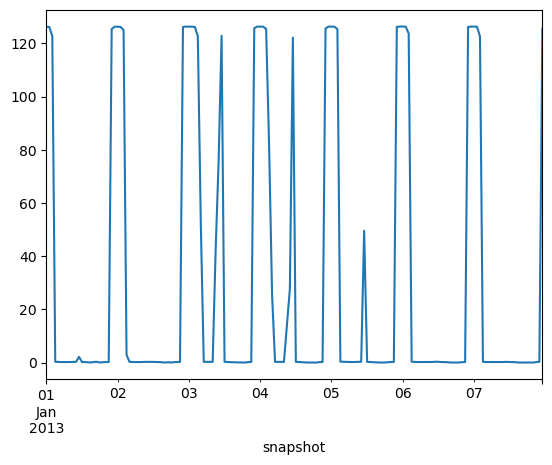

In [275]:
gen_indices = n.generators.query(f"carrier == '{'CCGT'}'").index
gens_ccgt = n.generators_t.p[gen_indices]
gens_ccgt.iloc[:168,1].plot()

<AxesSubplot:xlabel='snapshot'>

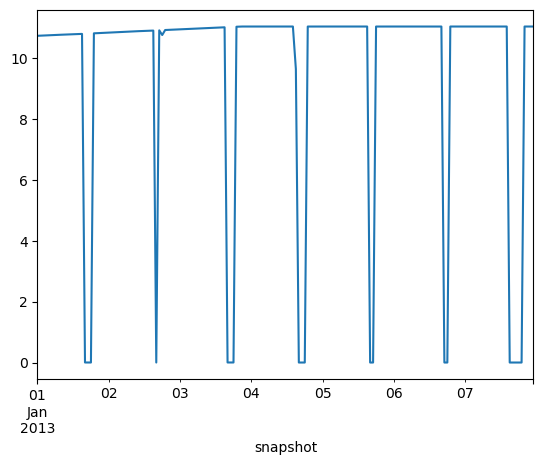

In [276]:
gen_indices = n.storage_units.query(f"carrier == '{'hydro'}'").index
dispatch_50 = n.storage_units_t.p[gen_indices]
dispatch_50.iloc[:168,2].plot()


In [277]:
gens = n.generators

In [278]:
storage = n.storage_units

In [279]:
lines = n.lines

In [280]:
lines_dispatch = n.lines_t.p0
storage_dispatch = n.storage_units_t.p
gen_dispatch = n.generators_t.p

In [281]:
def get_emissions(network):
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    return emissions.sum().sum() / 1000000

In [282]:
get_emissions(n)

1.0541877504591437

In [283]:
file_path = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/resources/demand_profiles.csv'
data = pd.read_csv(file_path)
column_sums = data.drop('time', axis=1).sum()
sums_df = pd.DataFrame([column_sums], index=['Sum'])

In [284]:
loads = n.loads_t.p_set
loads.sum()

Load
2      3.665741e+03
4      2.217177e+05
8      8.895242e+04
10     1.009627e+06
12     6.545045e+04
           ...     
96     2.518860e+04
97     1.638944e+05
98     5.464147e+05
99     7.068063e+04
100    7.597200e+05
Length: 61, dtype: float64

# Load distribution plot

c:\Users\noraky\anaconda3\envs\pypsa-earth-nora\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


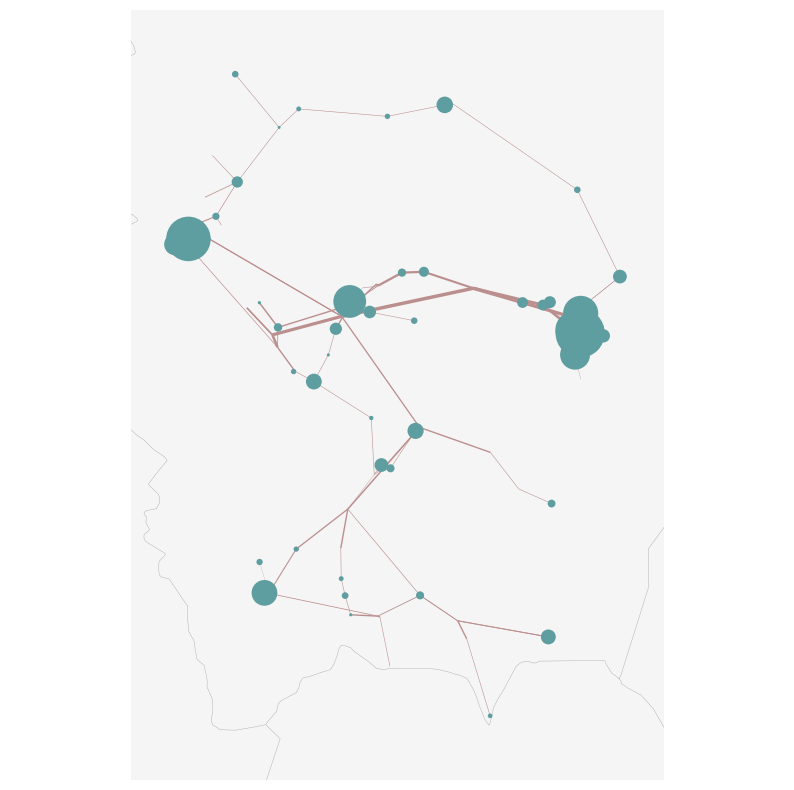

In [285]:
max_node_size = 0.1  # maximum size of a node for plotting purposes [used in plots]

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off")
plt.show()



In [286]:
storage = n.storage_units

In [287]:
gens = n.generators

In [288]:
dispatch = pd.DataFrame(n.generators_t.p)

In [289]:
lines = n.lines

c:\Users\noraky\anaconda3\envs\pypsa-earth-nora\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\noraky\anaconda3\envs\pypsa-earth-nora\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\noraky\anaconda3\envs\pypsa-earth-nora\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dt

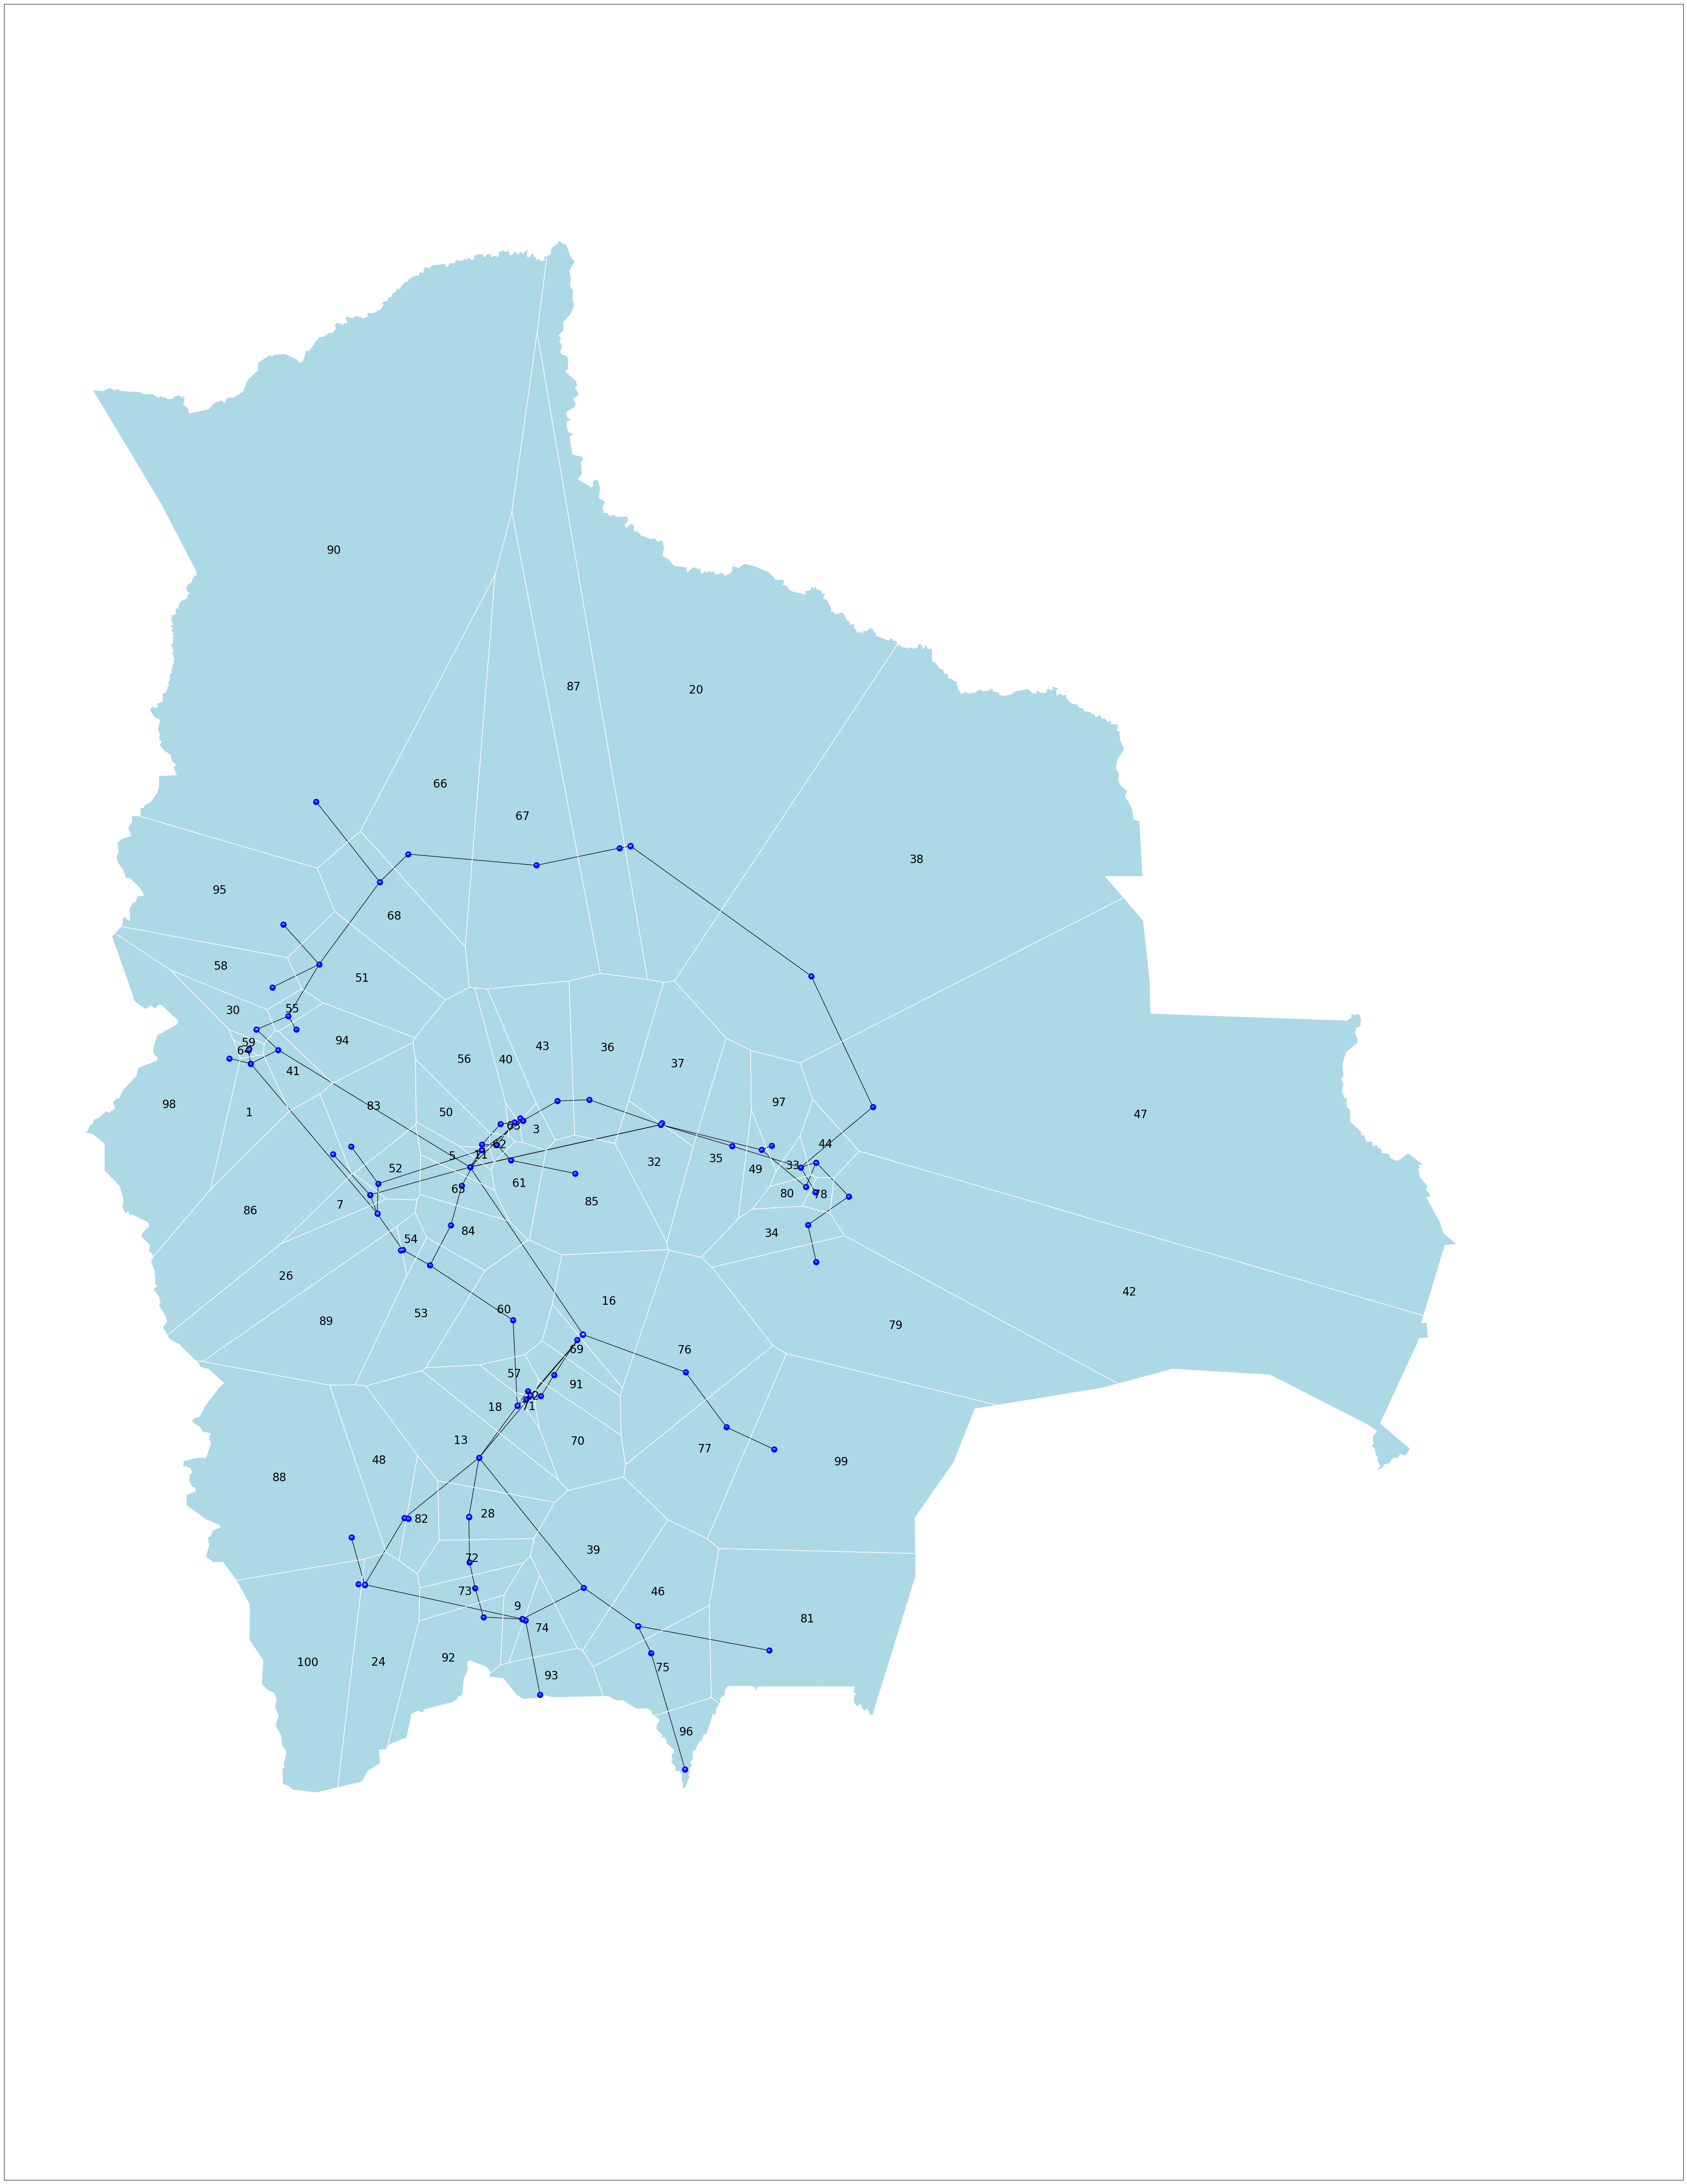

In [5]:
import cartopy.crs as ccrs
import geopandas as gpd
plot_capfacs_onwind = (
    "onwind"  # colors in the back represent capacity factors for this technology
)
home = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/'
 
G = nx.Graph()
 
# Read the CSV files
df_buses = pd.read_csv("C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/resources/base_network/all_buses_build_network.csv")
df_lines = pd.read_csv("C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/resources/base_network/all_lines_build_network.csv")
df_transformers = pd.read_csv("C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/resources/base_network/all_transformers_build_network.csv")
 
# Combine dataframes
df1 = df_lines[["bus0", "bus1"]]
df3 = df_transformers[["bus0", "bus1"]]
df4 = pd.concat([df1, df3])
 
# Create graph from edge list
G = nx.from_pandas_edgelist(df4, 'bus0', 'bus1')
 
# Create a position dictionary based on coordinates
pos = {node: (row['lon'], row['lat']) for node, row in df_buses.iterrows()}
pos = {row['bus_id']: (row['lon'], row['lat']) for _, row in df_buses.iterrows()}

green1 = '#294839'
green2 = '#6E966E'
green3 = '#A3BDA3'
 
fig, ax1 = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()},figsize = (70,70))
 
 
network_path = "C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/base_NZE/BNZE__2040.nc"
n = pypsa.Network(network_path)
r = gpd.read_file(home +
    f"resources/bus_regions/regions_onshore_elec_s.geojson"
).set_index("name")
 
# 4 clusters network boundaries
ax1.set_xlim(left=min(n.buses.x)-2.0, right=max(n.buses.x)+7.2)
ax1.set_ylim(bottom=min(n.buses.y)-3.5, top=max(n.buses.y)+6.8)
 
r.boundary.plot(ax=ax1, color='white', linewidth=1, alpha=1)
 
r.plot(ax=ax1, color="lightblue", alpha=1, vmin=0, vmax=1)
 
# Add text to r.plot to show the zone names
for idx, row in r.iterrows():
    ax1.text(row.geometry.centroid.x, row.geometry.centroid.y, s=row.name, horizontalalignment='center', verticalalignment='center', fontsize=20, color='black')
 
# Draw the main graph
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='blue')
# Draw edges
nx.draw_networkx_edges(G, pos, width=1)
 
# Add labels with indices inside the nodes
for node, (x, y) in pos.items():
    plt.text(x, y, s=node, horizontalalignment='center', verticalalignment='center', fontsize=5, color='white')
   
for node_id in G.nodes():  # Ensure you're iterating over the graph's nodes
    x, y = pos[node_id]
    degree = G.degree[node_id]  # This should not raise KeyError if node_id is in G
 
# Add labels with coordinates next to the nodes
for node, (x, y) in pos.items():
    coord_text = f'({x:.2f}, {y:.2f})'
    #degree = G.degree[node]
    offset_x = 0.02 + 0.005 * degree
    offset_y = 0.02 + 0.005 * degree
    #plt.text(x + offset_x, y + offset_y, s=coord_text, horizontalalignment='left', verticalalignment='bottom', fontsize=8, color='green')